In [1]:
import os
import csv
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
# =================================================================
# 1. MOTEUR MATHÉMATIQUE STABLE (TCHEBICHEF)
# =================================================================

def tchebichef_polynomials(N, order):
    """Calcule les polynômes via la récurrence de Mukundan."""
    M = np.zeros((order, N))
    x = np.arange(N)
    M[0, :] = 1.0
    if order > 1:
        M[1, :] = (2.0 * x - N + 1.0) / N
    for p in range(2, order):
        term1 = ((2.0 * p - 1.0) * (2.0 * x - N + 1.0)) / (p * N)
        term2 = ((p - 1.0) / p) * (1.0 - ((p - 1.0)**2 / (N**2)))
        M[p, :] = term1 * M[p-1, :] - term2 * M[p-2, :]
    return M

def calculate_rho(N, order):
    """Constante de normalisation pour l'orthogonalité."""
    rho = np.zeros(order)
    rho[0] = N
    for p in range(1, order):
        term1 = (N**2 - p**2) / (N**2)
        term2 = (2*p - 1) / (2*p + 1)
        rho[p] = term1 * term2 * rho[p-1]
    return rho

def decompose_2d(image, requested_order):
    """Génère la matrice des moments avec sécurité sur la taille de l'image."""
    H, W = image.shape
    
    # On limite l'ordre de calcul à la taille réelle de la lésion
    actual_order_h = min(requested_order, H)
    actual_order_w = min(requested_order, W)
    
    M_h = tchebichef_polynomials(H, actual_order_h)
    M_w = tchebichef_polynomials(W, actual_order_w)
    rho_h = calculate_rho(H, actual_order_h)
    rho_w = calculate_rho(W, actual_order_w)
    
    # Calcul des moments
    T_raw = M_h @ image @ M_w.T
    C_pq = 1.0 / np.outer(rho_h, rho_w)
    T_pq_small = T_raw * C_pq
    
    # On remplit une matrice 10x10 (ou l'ordre demandé) avec des zéros pour l'IA
    T_final = np.zeros((requested_order, requested_order))
    T_final[:actual_order_h, :actual_order_w] = T_pq_small
    
    return T_final

def reconstruct_2d(moments, shape_originale):
    """Reconstruit l'image à partir des moments T_pq."""
    H, W = shape_originale
    order = moments.shape[0]
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    return M_h.T @ moments @ M_w



In [3]:
# =================================================================
# 2. PARAMÈTRES ET CHARGEMENT
# =================================================================

PATIENT = "P1"
TIMEPOINT = "T1"
MODALITY = "FLAIR" 
# Ajustez le chemin selon votre structure de dossier
BASE_DIR = f"../../../27919209/MSLesSegDataset/train/{PATIENT}/{TIMEPOINT}"

mask_path = os.path.join(BASE_DIR, f"{PATIENT}_{TIMEPOINT}_MASK.nii.gz")
img_path  = os.path.join(BASE_DIR, f"{PATIENT}_{TIMEPOINT}_{MODALITY}.nii.gz")
output_dir = "Moments_Output"
os.makedirs(output_dir, exist_ok=True)

# Lecture des images
mask_sitk = sitk.ReadImage(mask_path)
img_sitk  = sitk.ReadImage(img_path)

mask_bin = sitk.Cast(mask_sitk > 0, sitk.sitkUInt8)
lesion_cc = sitk.ConnectedComponent(mask_bin)
lesion_cc = sitk.RelabelComponent(lesion_cc) # Tri par volume

mask_arr = sitk.GetArrayFromImage(lesion_cc)
img_arr  = sitk.GetArrayFromImage(img_sitk)



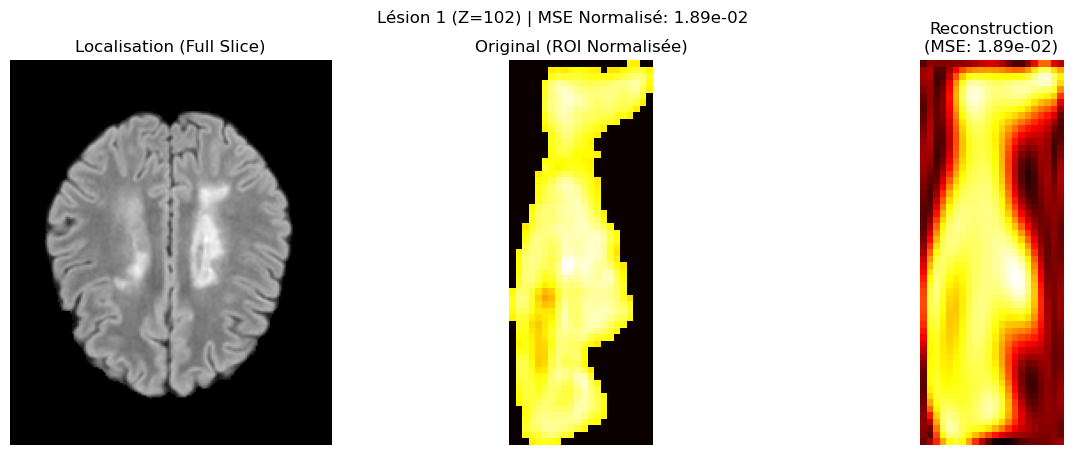

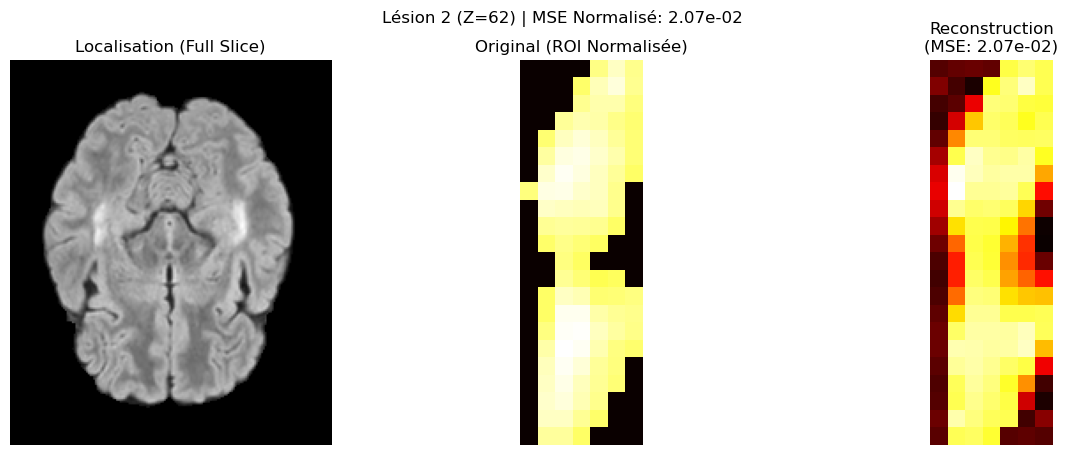

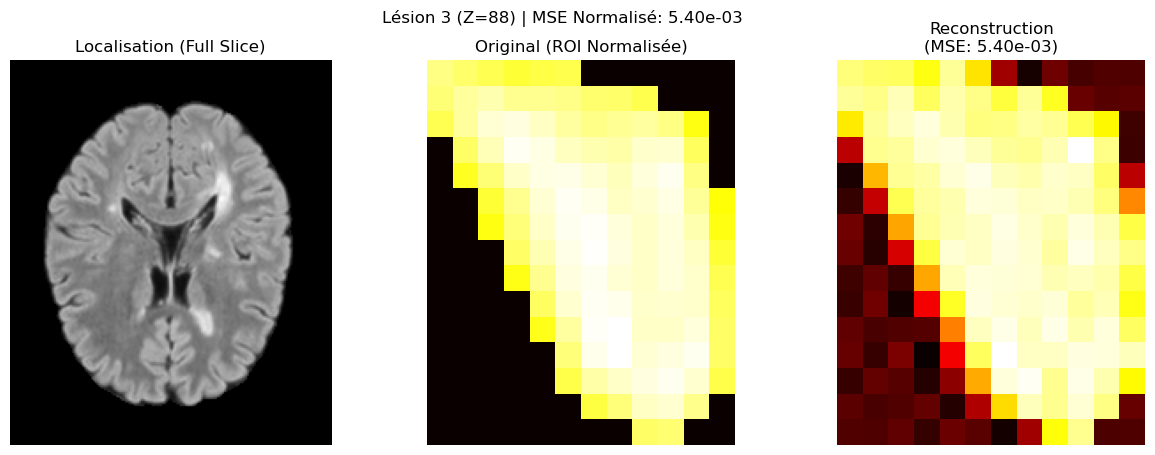

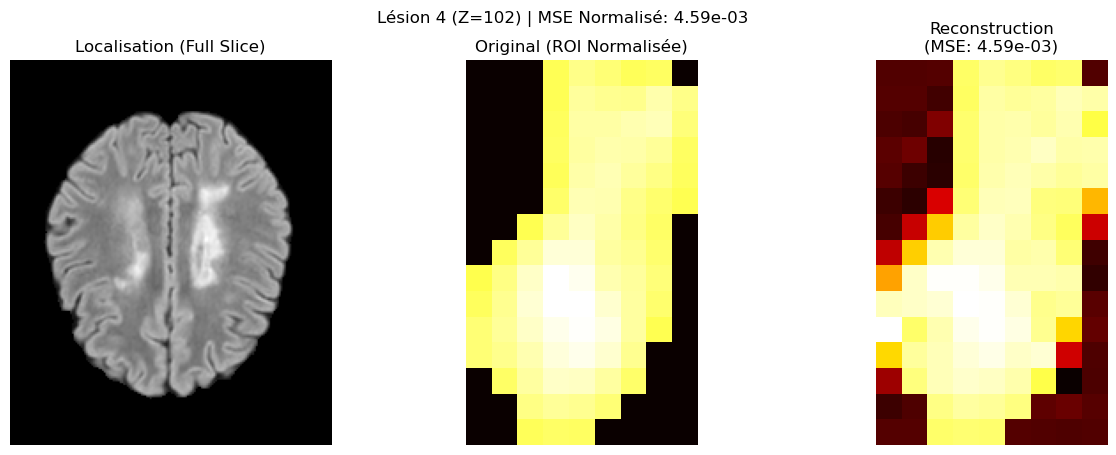

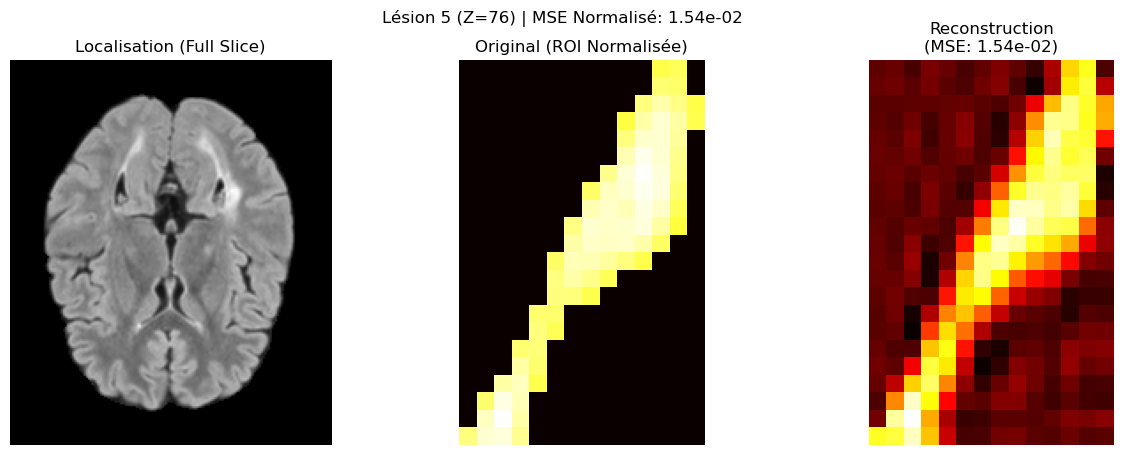

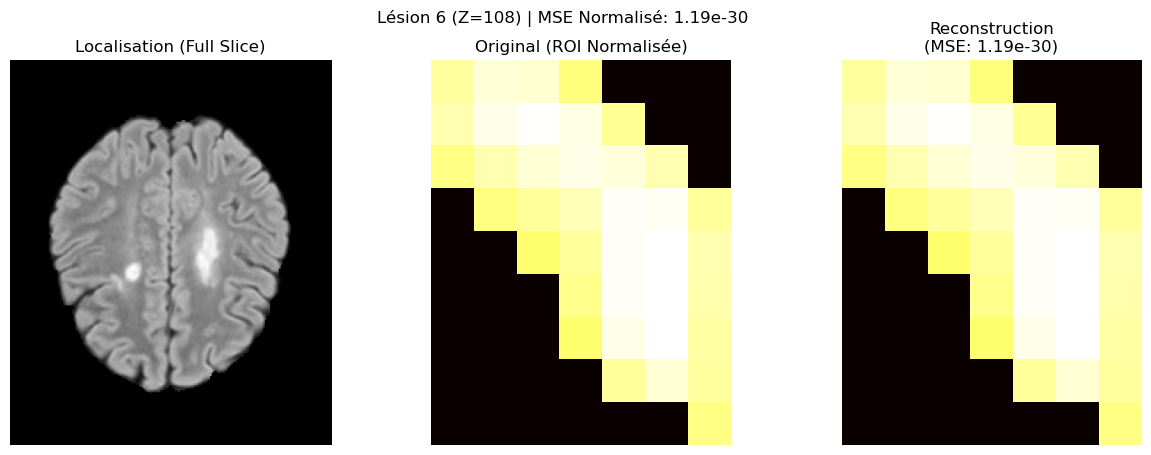

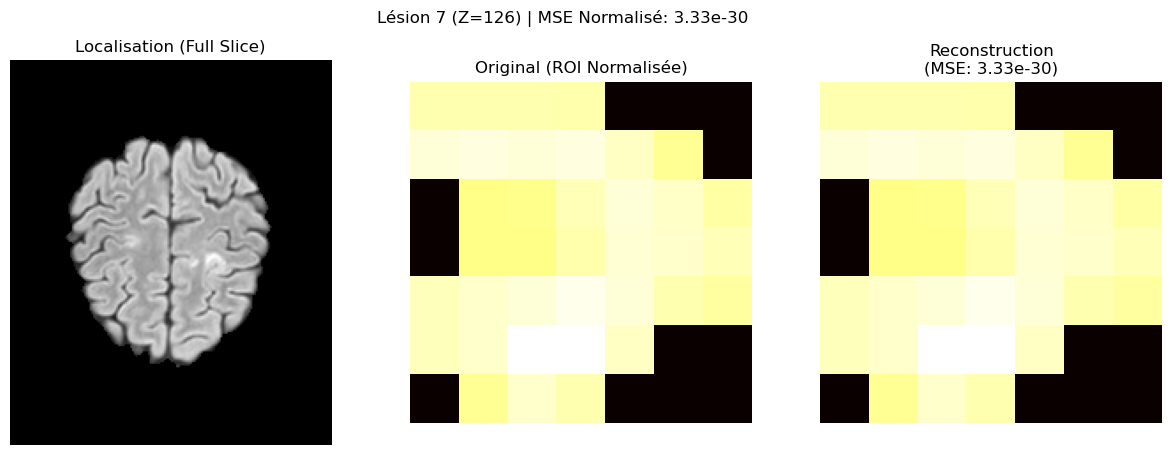

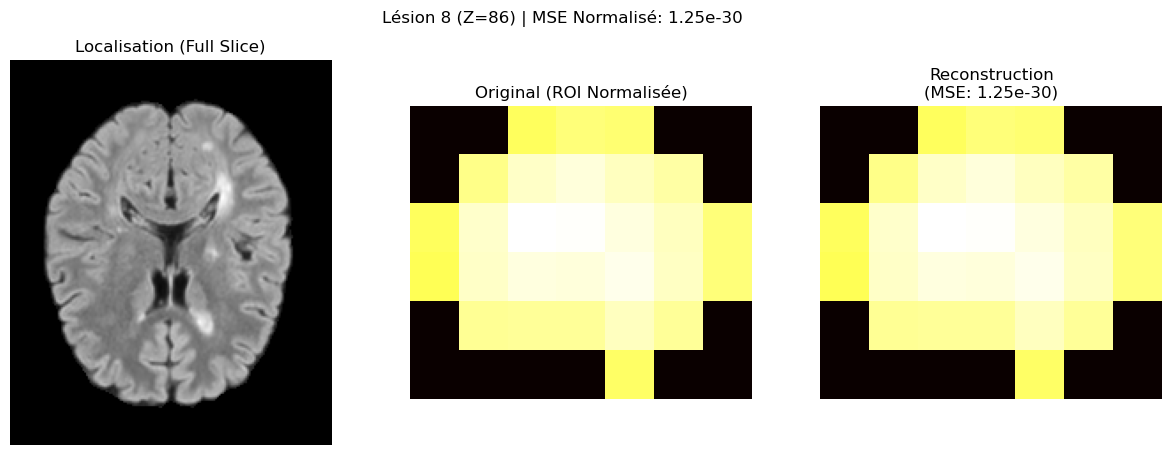

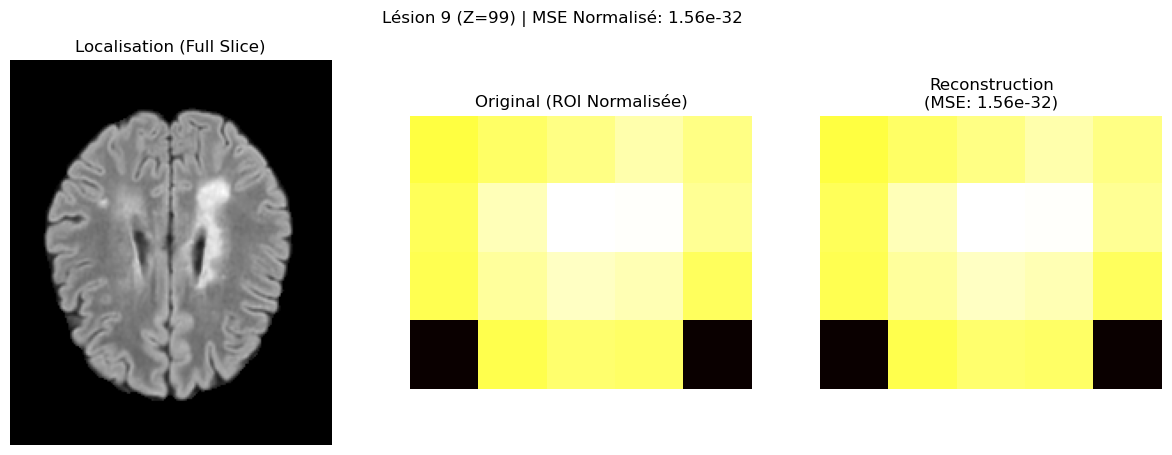

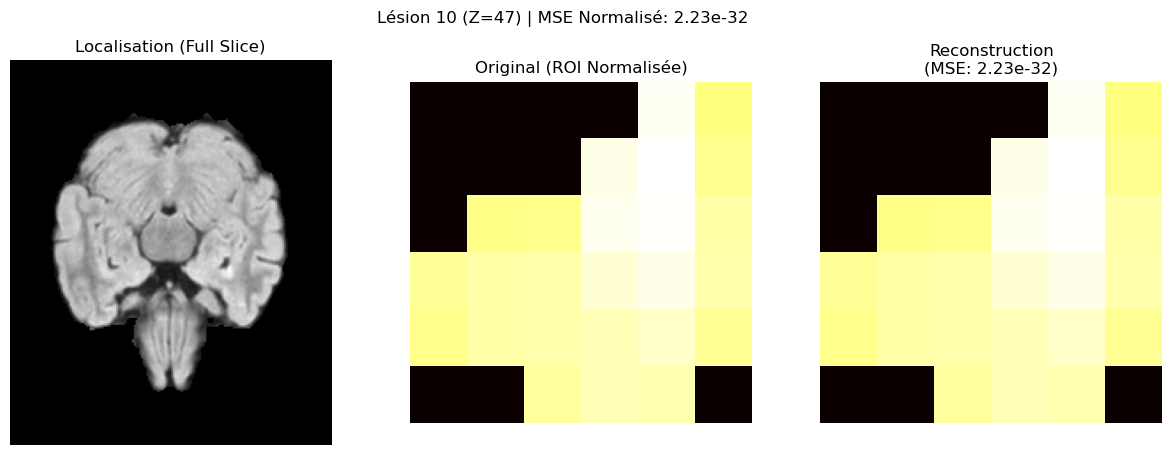

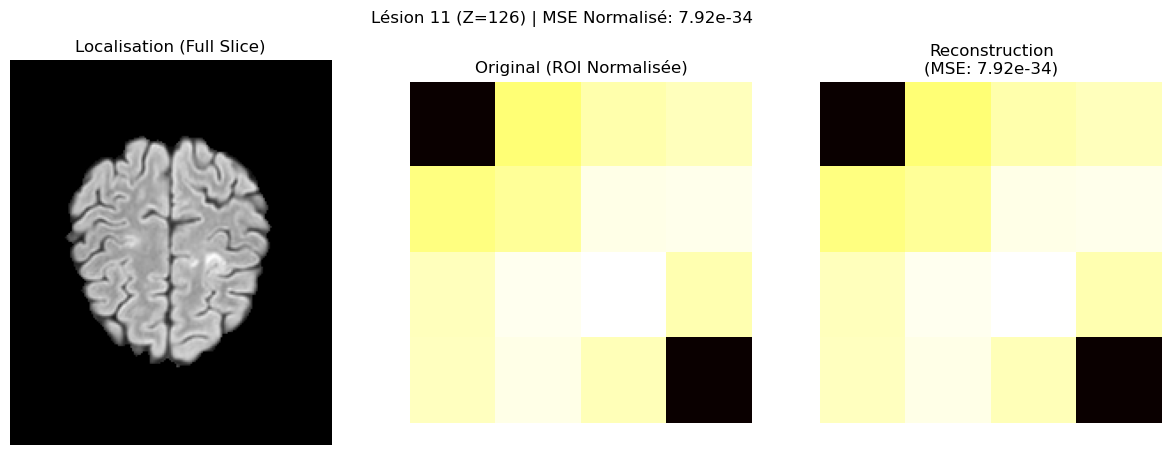

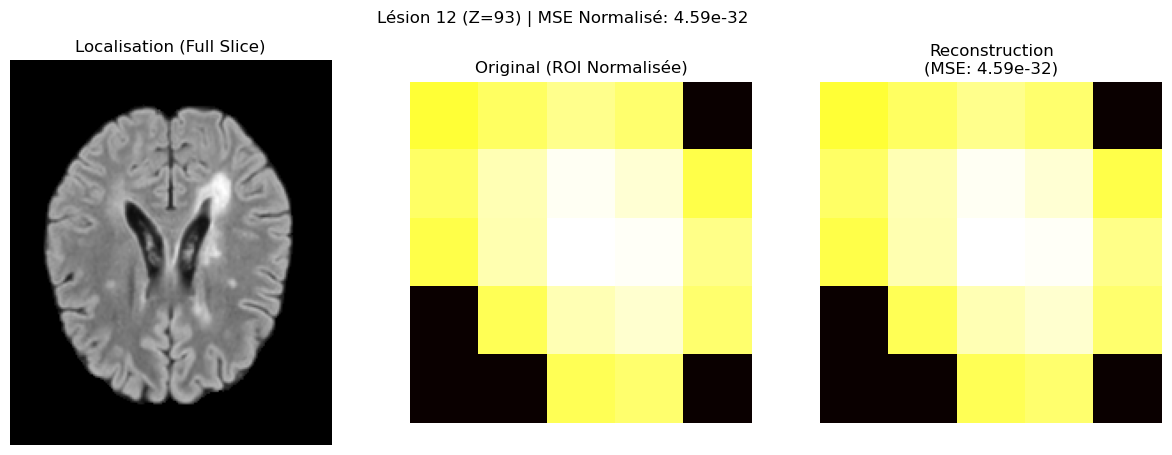

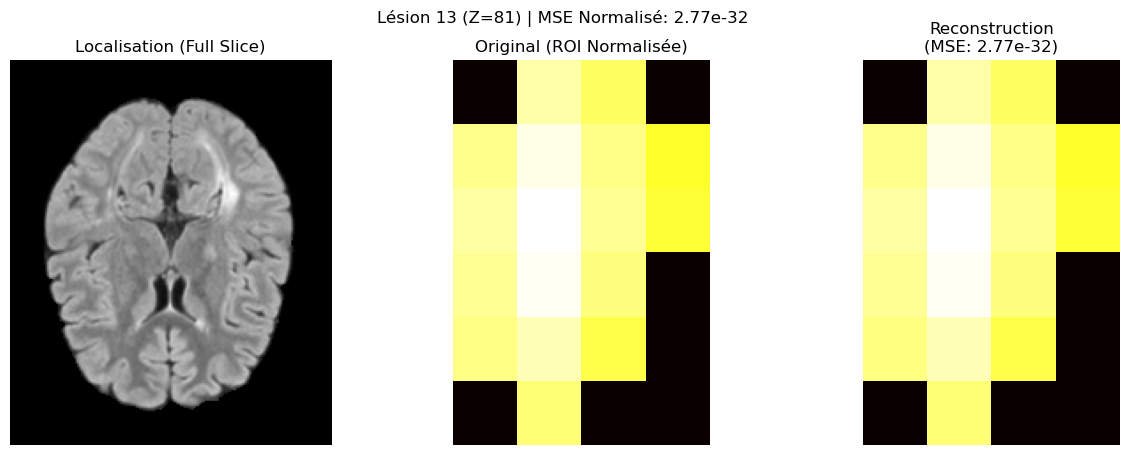

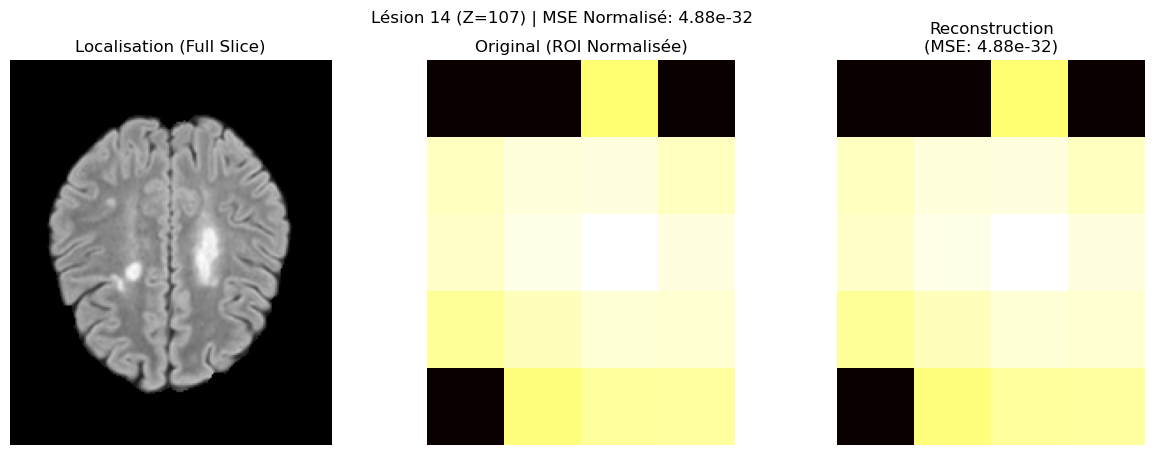

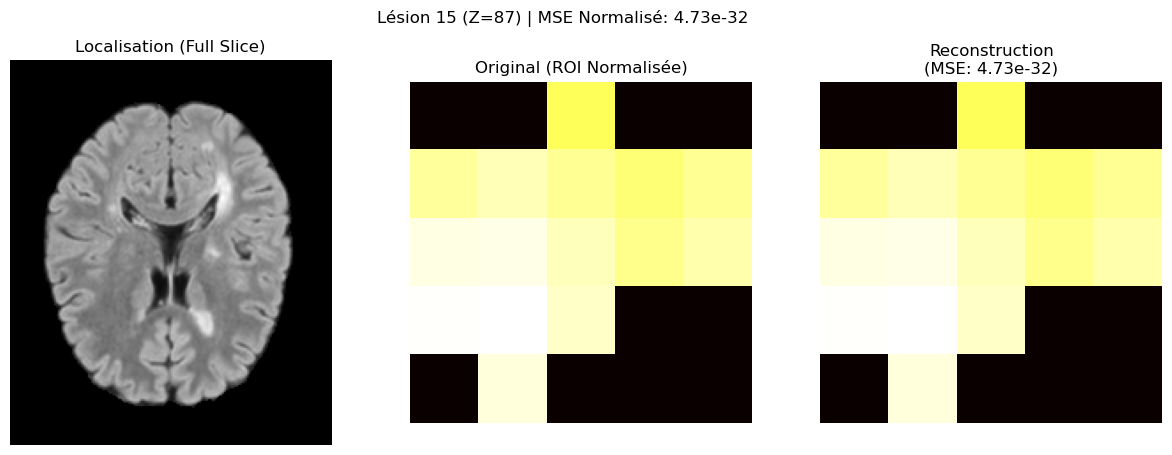

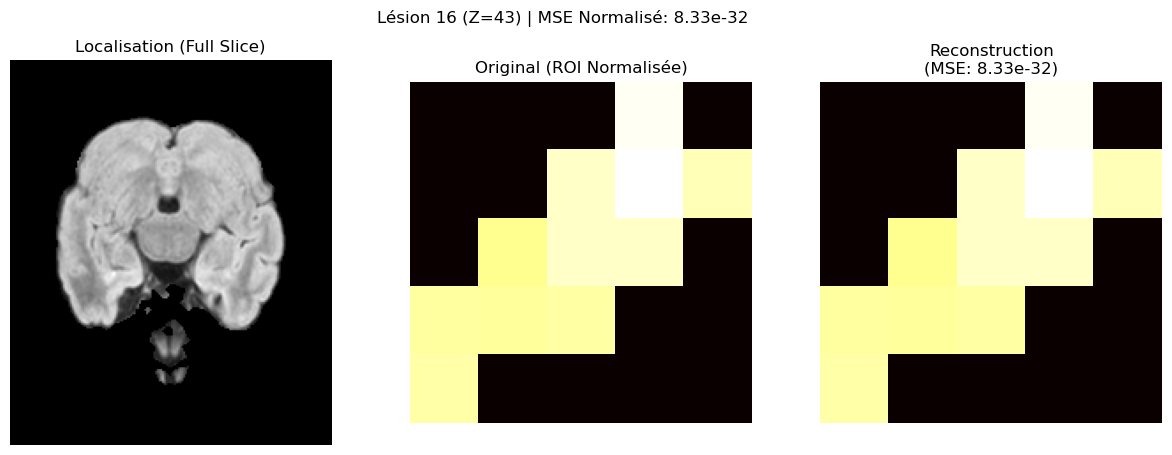

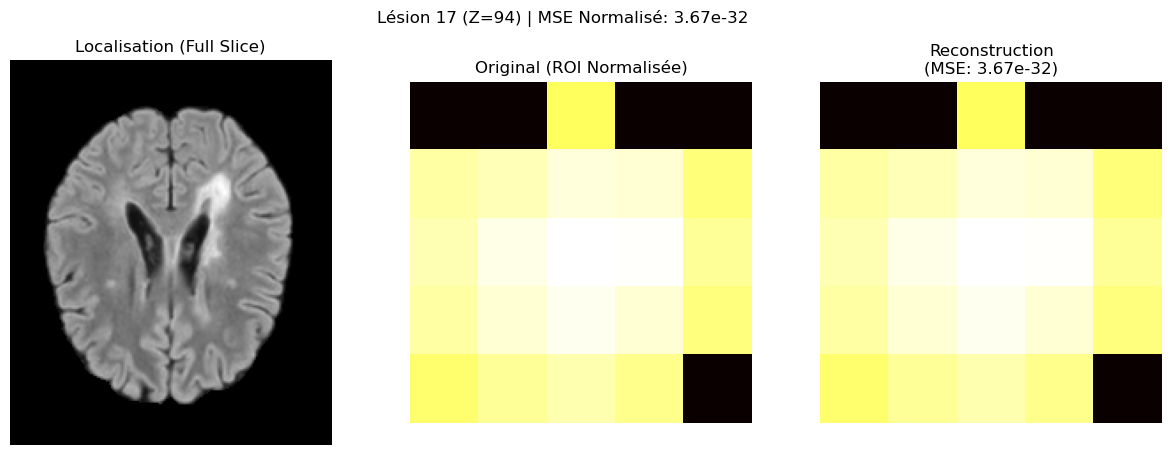

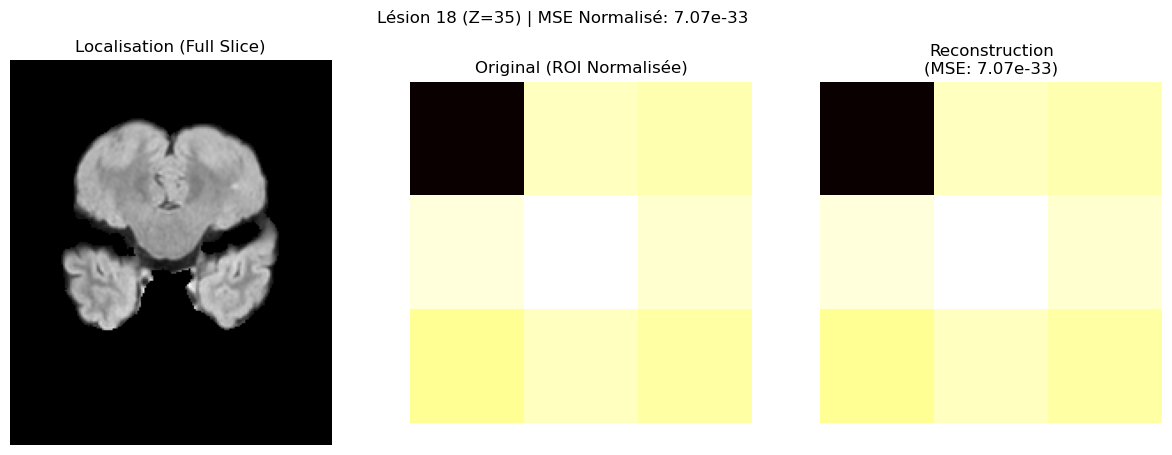


Traitement du patient P1 terminé.


In [4]:
# =================================================================
# 3. EXTRACTION ET SAUVEGARDE
# =================================================================
num_lesions = int(mask_arr.max())
ORDRE_CIBLE = 10

for l_id in range(1, num_lesions + 1):
    # 1. Détection de la meilleure coupe (Surface Max)
    lesion_mask_3d = (mask_arr == l_id)
    areas = lesion_mask_3d.sum(axis=(1, 2))
    best_z = np.argmax(areas)
    
    # 2. Extraction et Crop (Bounding Box)
    slice_img = img_arr[best_z, :, :]
    slice_mask = lesion_mask_3d[best_z, :, :]
    ys, xs = np.where(slice_mask)
    
    if len(ys) < 2 or len(xs) < 2: 
        print(f"Lésion {l_id} : Trop petite pour analyse.")
        continue
    
    # Extraction de la ROI (Intensité * Masque)
    lesion_roi = slice_img[ys.min():ys.max()+1, xs.min():xs.max()+1] * \
                 slice_mask[ys.min():ys.max()+1, xs.min():xs.max()+1]

    # --- MODIFICATION : NORMALISATION DE L'INTENSITÉ ---
    # On ramène les pixels entre 0 et 1 pour stabiliser le MSE
    max_val = np.max(lesion_roi)
    lesion_roi_norm = lesion_roi / max_val if max_val > 0 else lesion_roi

    # 3. Calcul et Reconstruction
    try:
        # Calcul sur l'image normalisée
        moments_10x10 = decompose_2d(lesion_roi_norm, ORDRE_CIBLE)
        
        # Reconstruction pour validation
        reconstruction = reconstruct_2d(moments_10x10, lesion_roi_norm.shape)
        
        # Calcul du MSE sur les valeurs normalisées
        mse = np.mean((lesion_roi_norm - reconstruction)**2)
        
        # 4. Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Lésion {l_id} (Z={best_z}) | MSE Normalisé: {mse:.2e}", fontsize=12)
        
        axes[0].imshow(slice_img, cmap='gray')
        axes[0].set_title("Localisation (Full Slice)")
        
        axes[1].imshow(lesion_roi_norm, cmap='hot')
        axes[1].set_title("Original (ROI Normalisée)")
        
        axes[2].imshow(reconstruction, cmap='hot')
        axes[2].set_title(f"Reconstruction\n(MSE: {mse:.2e})")
        
        for ax in axes: ax.axis('off')
        plt.show()

        # 5. Sauvegarde CSV (10x10 coefficients)
        filename = f"{PATIENT}_{TIMEPOINT}_{MODALITY}_L{l_id}_Cheby.csv"
        save_path = os.path.join(output_dir, filename)
        with open(save_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(moments_10x10)
            
    except Exception as e:
        print(f"Erreur sur la lésion {l_id} : {e}")

print(f"\nTraitement du patient {PATIENT} terminé.")